Our first step is to import the necessary libraries for our program. I will be using librosa for sound analysis and feature extraction from the audio provided. 

In [1]:
# feature extracting and preprocessing data
from librosa import feature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import soundfile as sf

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

The music files have been extracted and stored on board the computer in the directory specified. 
The below code extracts the songs from the directory by making use of their folder name and places them in the empty list 'musics'.

In [2]:
directory = '/home/vibhhu/Downloads/Analytics'
GENRES = ['rock','classical']

def generate_audio_values(genres:list=GENRES,PATH_STRING:str="/home/vibhhu/Downloads/Analytics/")->list:    
    musics = []
    for genre in genres:
        g = []
        for filename in os.listdir(f"{PATH_STRING}{genre}"):
            g.append(sf.read(os.path.join(f"{PATH_STRING}{genre}",filename)))
        musics.append(g)
    return musics


In [3]:
musics = generate_audio_values()

The following function generates the features that I will be using.
24 features are being used in total. For each 1dfeature, the first and second delta have also been used as features in the form of mean and standard deviation both.

    MFCC (12 coefficients)
    
    Spectral Centroid
    
    Zero Crossing Rate
    
    RMS
    
    Spectral Flatness
    
    Delta (1st and 2nd order of each feature)

In [4]:
def generate_audio_features(musics:list=musics)->pd.DataFrame:    
    labels = range(len(musics))
    features1d = {feature.spectral_centroid: False,  
                  feature.rms: False, 
                  feature.spectral_flatness: False,
                  feature.zero_crossing_rate:False,
                  feature.mfcc: True}
    f_size=len(features1d)*2*3+1 #2 because of mean and std_dev, 3 because of feature, delta1,delta2
    feature_array = np.zeros(f_size).reshape(1,f_size)
    for i, genre in enumerate(musics):
        for music, samplerate in genre:
            x = np.array([])
            for feat in features1d.keys():
                if features1d[feat]:
                    f = feat(music, sr=samplerate)
                else:
                    f = feat(music)
                f_delta = feature.delta(f) 
                f_2delta = feature.delta(f, order=2)
                x = np.hstack([x,np.array([f.mean(), np.std(f), f_delta.mean(), np.std(f_delta), f_2delta.mean(), np.std(f_2delta)])])
            x = np.hstack([x,i])
            feature_array = np.vstack([feature_array, x])
    return pd.DataFrame(data=feature_array).drop(0)

df_sound = generate_audio_features()
df_sound

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
1,2947.094507,1004.622346,-0.613578,203.310413,-0.193616,105.000294,0.060483,0.028142,0.000061,0.005319,...,0.013636,-0.000014,0.006592,-5.124719,54.378860,0.007360,3.084564,0.002211,1.622223,0.0
2,2626.720259,638.047780,0.010545,122.189793,0.094756,77.355417,0.113413,0.031370,0.000030,0.006831,...,0.009012,-0.000029,0.005099,0.142759,28.917587,0.005428,2.636780,0.003802,1.723364,0.0
3,2944.360600,850.914582,-0.677628,157.988276,-0.839670,111.767716,0.096537,0.022351,0.000016,0.003836,...,0.011220,-0.000066,0.006727,0.069596,38.963562,-0.003587,2.739550,0.001347,1.852764,0.0
4,2794.957194,580.993104,-0.356932,83.550186,0.310166,46.128263,0.219387,0.065393,0.000010,0.008808,...,0.007310,-0.000031,0.003844,4.750198,21.321001,0.003194,2.050160,-0.002724,1.228541,0.0
5,3361.723252,551.504263,0.123265,107.843460,-0.044224,57.885008,0.190228,0.043412,0.000094,0.008912,...,0.011553,-0.000062,0.005867,4.857758,16.356693,-0.000862,1.777502,0.002855,1.033213,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1533.668230,433.146488,-0.538678,30.362959,-0.211008,16.614149,0.041533,0.030369,-0.000087,0.004009,...,0.003812,-0.000040,0.002106,-11.052116,71.136246,-0.001981,1.639163,0.001454,0.885212,1.0
197,1494.419821,303.798708,-0.056042,36.942360,0.023914,23.454888,0.036720,0.021561,-0.000039,0.003792,...,0.003814,-0.000038,0.002070,-8.555452,69.629501,-0.000003,1.783387,0.000411,1.041409,1.0
198,1803.912154,418.461672,-0.133839,80.640461,0.238662,40.264683,0.068755,0.026954,-0.000037,0.004290,...,0.005212,-0.000015,0.002730,-6.786133,49.173775,0.002429,2.675955,-0.000961,1.549132,1.0
199,1807.889891,471.154457,0.319383,36.066341,0.085304,18.978762,0.084150,0.037937,0.000014,0.004461,...,0.003615,-0.000021,0.001636,-6.809309,75.339806,-0.003587,1.494878,0.000680,0.846397,1.0


Having extracted the required features, I now try to find the best possible model to fit them.

In [5]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import pylab

In [6]:
scaler = StandardScaler()

The below block standardizes features by removing the mean and scaling to unit variance

In [7]:
X,y = df_sound.values[:,:-1], df_sound.values[:,-1]
scaler.fit(X)
X = scaler.transform(X)
Xdf=pd.DataFrame(X)


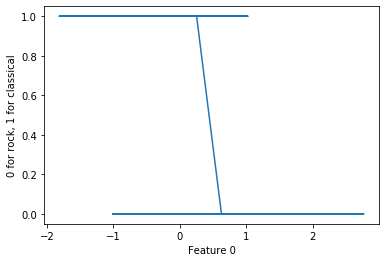

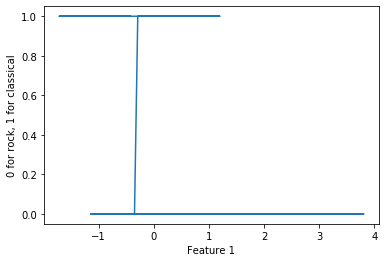

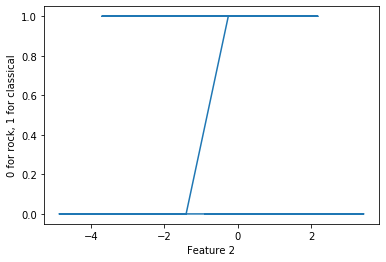

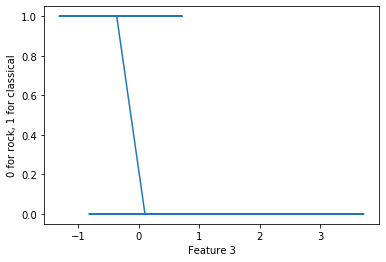

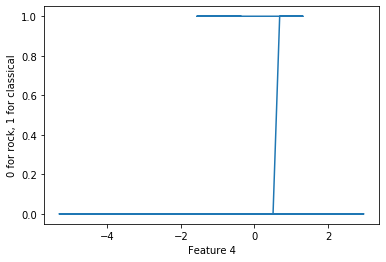

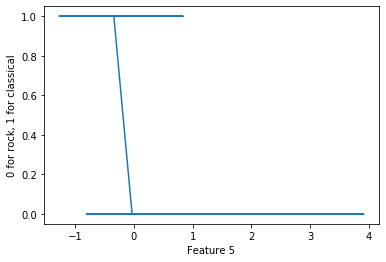

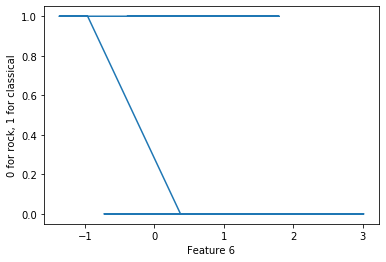

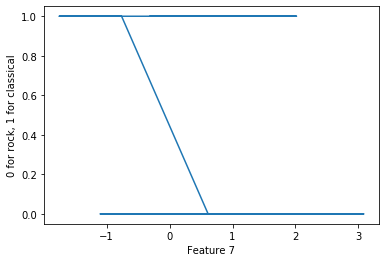

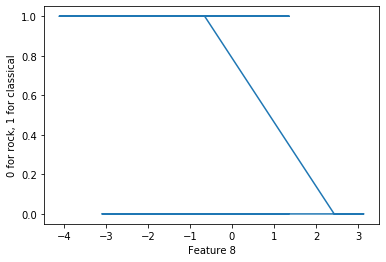

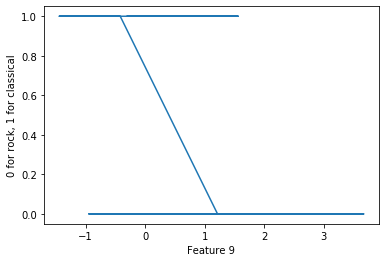

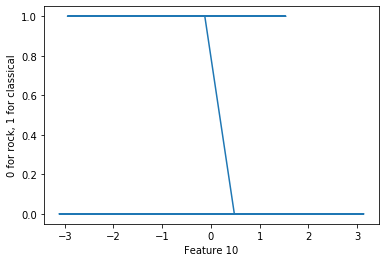

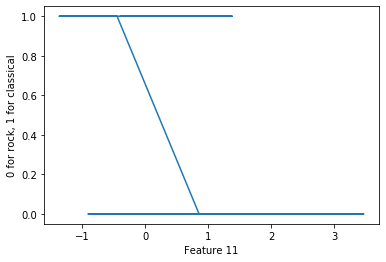

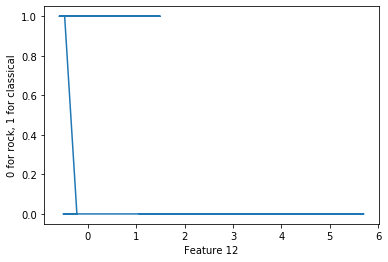

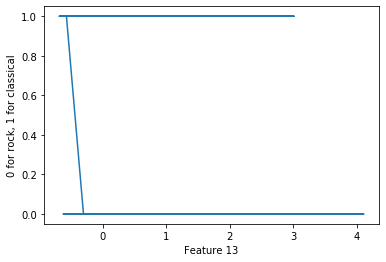

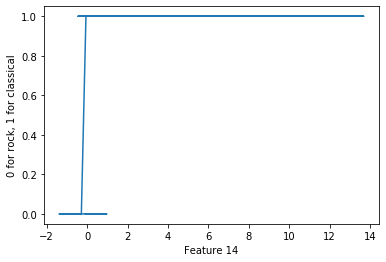

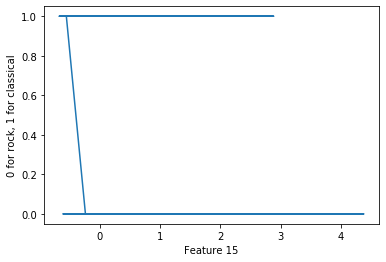

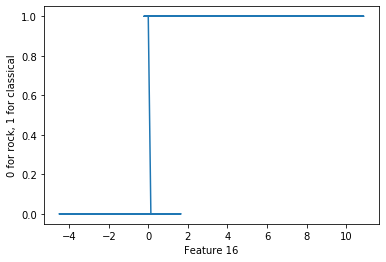

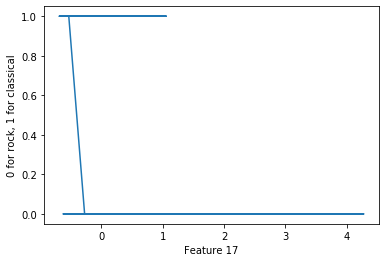

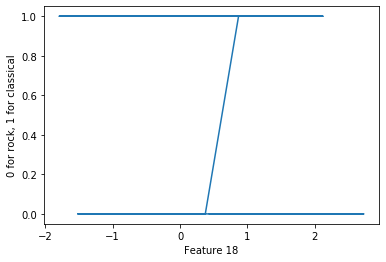

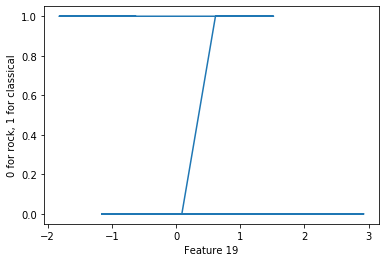

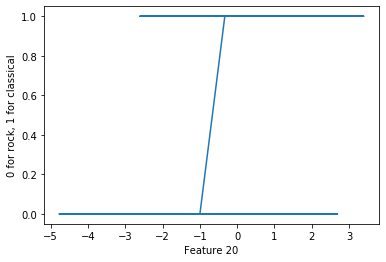

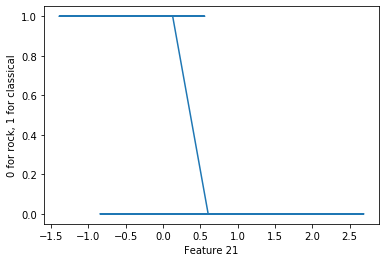

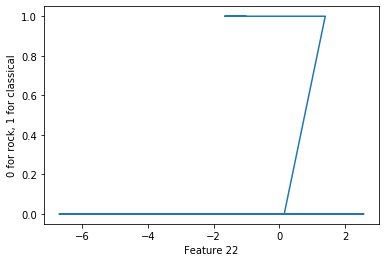

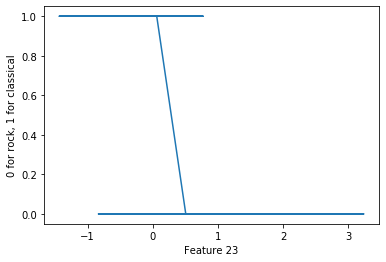

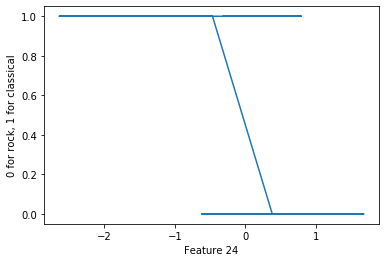

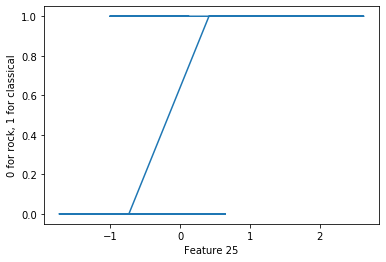

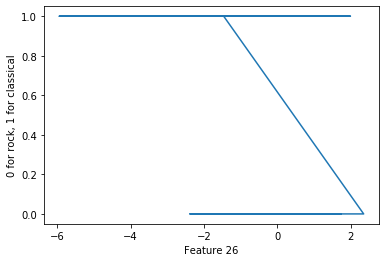

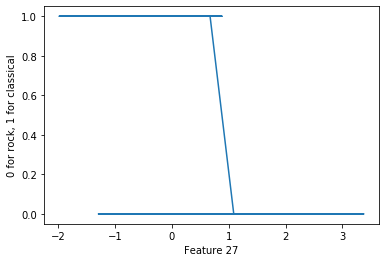

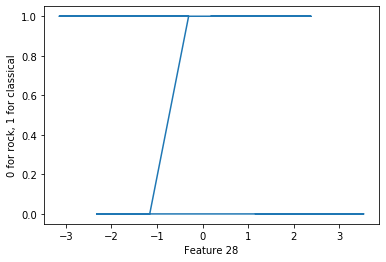

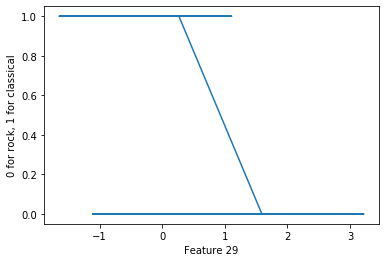

In [8]:
for i in range(0,30):
    plt.figure(i)
    plt.plot(Xdf[i],y)
    plt.ylabel("0 for rock, 1 for classical")
    plt.xlabel("Feature %d"%i)
    #plt.savefig("sample%d.png"%i)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

My first model will be a k-nearest neighbours classifier. Firstly, I find the optimal value of k by plotting the score of the model with varying k.

Text(0, 0.5, 'Score')

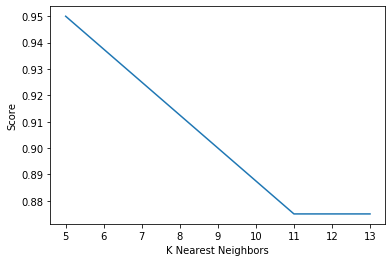

In [10]:
MIN, MAX, STEP = 5, 15, 2
models = [KNeighborsClassifier(n_neighbors=i) for i in range(MIN,MAX,STEP)]
for i, model in enumerate(models):
    models[i].fit(X_train,y_train)

plt.plot(range(MIN,MAX,STEP),[model.score(X_test, y_test) for model in models])
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Score")
#KNN Prediction

At optimal k, accuracy is observed to be around 0.95.
I now try an SVM model on the data.

Text(0, 0.5, 'Score')

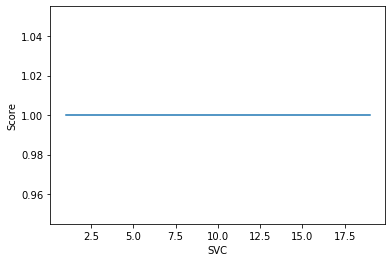

In [11]:
from sklearn.svm import SVC
MIN, MAX, STEP = 1, 21, 2
models = [SVC(C=i,kernel="linear",probability=True) for i in range(MIN,MAX,STEP)]
for i, model in enumerate(models):
    models[i].fit(X_train,y_train)

plt.plot(range(MIN,MAX,STEP),[model.score(X_test, y_test) for model in models])
plt.xlabel("SVC")
plt.ylabel("Score")


The above graph shows that adjusting the value of C only improves the accuracy upto a maximum of 1.0. This is an improvement on our base KNN model that gave an accuracy of 0.95. The following code-block prints the score taking C=9, which is one of the optimal values.

In [12]:
model = SVC(C=9,kernel="linear",probability=True)
model.fit(X_train,y_train)
print(i,model.score(X_test,y_test))
#SVM prediction

9 1.0


We have achieved 100% accuracy. But this might not really be a perfect model. There is definitely a fear of overfitting and the 100% result might actually be misleading and fail on a larger dataset.
To improve our prediction by reducing the possibility of overfitting, I will be introducing a cross-validation set and also try to see if a lesser number of features does the job better.
Before that, I plot a PCA graph of the current situation that illustrates the two distinction between the two genres in an easy to visualize form.

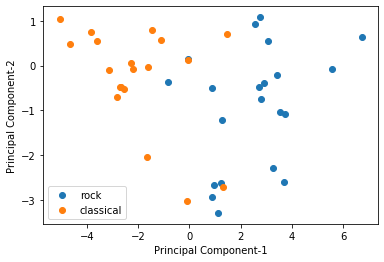

In [13]:
pca = PCA(2)
pca.fit(X_train)
trans_pca = pca.transform(X_test)

for i, _ in enumerate(GENRES):
    pylab.scatter(trans_pca[:,0][y_test==i], trans_pca[:,1][y_test==i],cmap='jet',label=GENRES[i])
pylab.xlabel("Principal Component-1")
pylab.ylabel("Principal Component-2")
pylab.legend()
pylab.show()
#PCA dimensionality reduction

RFECV allows me to choose an optimal number of features.
It checks the accuracy of a model with a given set of features on a cross validation set taken from the training set and return the set of features that provided the maximum accuracy.
The model I have passed to RFECV is a linear kernel SVM, since that was what gave the 1.0 accuracy on the training set.

Optimal number of features: 4
Selected features: [3, 5, 15, 24]


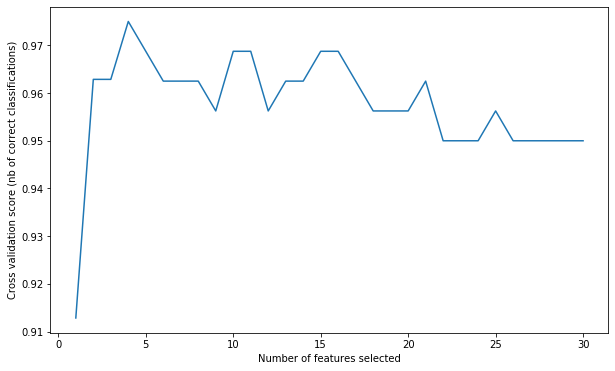

In [14]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=10, scoring='accuracy')
rfecv.fit(X_train, y_train)
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(Xdf.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


4 features namely, (3,5,15,24) have provided maximum prediction accuracy on the cross validation set. In fact, using all 30 features actually gives a low accuracy of around 0.955 on the cross-validation set-an indication that our previous answer of 1.0 on the training set was a sign of overfitting.

In [15]:
correlated_features = []
correlated_features = [[] for _ in range(30)]
for i in range(0,30):
    correlated_features[i].append(i)
correlation_matrix = Xdf.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.80:
            colname1 = correlation_matrix.columns[i]
            colname2=correlation_matrix.columns[j]
            if(i!=j):  
                correlated_features[i].append(colname2)
correlated_features

[[0, 18, 21, 23, 25],
 [1, 3, 5, 19, 21, 23],
 [2],
 [3, 1, 5, 21, 23, 29],
 [4],
 [5, 1, 3, 21, 23, 29],
 [6, 9, 11, 24, 25],
 [7, 9, 11],
 [8],
 [9, 6, 7, 11],
 [10],
 [11, 6, 7, 9],
 [12, 13, 15, 17],
 [13, 12, 15, 17],
 [14],
 [15, 12, 13, 17],
 [16],
 [17, 12, 13, 15],
 [18, 0],
 [19, 1, 21, 23],
 [20],
 [21, 0, 1, 3, 5, 19, 23],
 [22],
 [23, 0, 1, 3, 5, 19, 21],
 [24, 6, 25],
 [25, 0, 6, 24],
 [26],
 [27, 29],
 [28],
 [29, 3, 5, 27]]

The above code uses the correlation matrix and prins out, for each column, the other columns with with it is correlated to a degree>0.8.
The first element of each sublist is the corresponding column and the remaining elements are the columns correlated to that column.
RFECV told me that columns 3,5,15 and 24 give maximum accuracy on the cross-validation set.
Most of these features are unrelated to each to each other, however, feature 3 and feature 5 are related to each other.
In the next block of code, I print out the relative importances of each of these selected features towards my prediction.

In [16]:
np.absolute(rfecv.estimator_.coef_)[0]
#relative importances of selected features

array([1.05127148, 1.11399936, 0.67214573, 1.62235286])

Since both features have a relatively high importance and are correlated to the output, I do not remove either of them. The number of features is anyway low and isn't a burden on processing time.

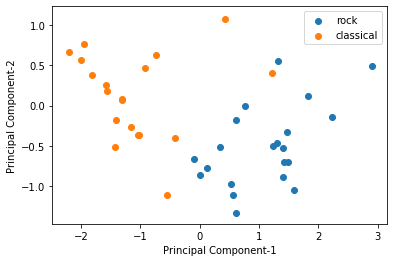

In [17]:
selected_features=[3,5,15,24]
xred=X_train[:,selected_features]
x_test=X_test[:,selected_features]
pca.fit(xred)
trans_pca = pca.transform(x_test)

for i, _ in enumerate(GENRES):
    pylab.scatter(trans_pca[:,0][y_test==i], trans_pca[:,1][y_test==i],cmap='jet',label=GENRES[i])
pylab.xlabel("Principal Component-1")
pylab.ylabel("Principal Component-2")
pylab.legend()
pylab.show()

Once again, I aim to find an optimal C value for my SVC.

Text(0, 0.5, 'Score')

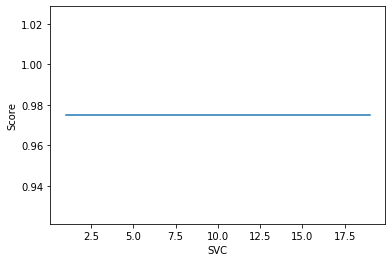

In [18]:
#Prediction on reduced features using logistic regression
for i, model in enumerate(models):
    models[i].fit(xred,y_train)

plt.plot(range(MIN,MAX,STEP),[model.score(x_test, y_test) for model in models])
plt.xlabel("SVC")
plt.ylabel("Score")

With all C's giving the same accuracy, I choose any C, say C=9, and train myfinal model on the reduced set of features.

In [19]:
model = SVC(C=9,kernel="linear",probability=True)
model.fit(xred,y_train)
print(i,model.score(x_test,y_test))

9 0.975


Finally, I obtain an accuracy of 0.975 on the training set. This indicates a single misclassified example.
Though this seems a step back from the original result of 1.0, it actually isn't becuase we have avoided overfitting the dataset-something which was being done by the previous model. This model will work better on general datasets.

The below code classifies the given songs into the two genres.

In [20]:
directory1 = '/home/vibhhu/Downloads/Analytics/Sample'

def generate_sample_values(PATH_STRING:str="/home/vibhhu/Downloads/Analytics/Sample/")->list:    
    sample = []
    for filename in os.listdir(f"{PATH_STRING}"):
        sample.append(sf.read(os.path.join(f"{PATH_STRING}",filename)))
    return sample


In [21]:
sample=generate_sample_values()

In [22]:
def generate_audio_features(sample:list=sample)->pd.DataFrame:    
    labels = range(len(musics))
    features1d = {feature.spectral_centroid: False,  
                  feature.rms: False, 
                  feature.spectral_flatness: False,
                  feature.zero_crossing_rate:False,
                  feature.mfcc: True}
    f_size=len(features1d)*2*3 #2 because of mean and std_dev, 3 because of feature, delta1,delta2
    feature_array = np.zeros(f_size).reshape(1,f_size)
    for music, samplerate in sample:
        x = np.array([])
        for feat in features1d.keys():
            if features1d[feat]:
                f = feat(music, sr=samplerate)
            else:
                f = feat(music)
            f_delta = feature.delta(f) 
            f_2delta = feature.delta(f, order=2)
            x = np.hstack([x,np.array([f.mean(), np.std(f), f_delta.mean(), np.std(f_delta), f_2delta.mean(), np.std(f_2delta)])])
        feature_array = np.vstack([feature_array, x])
    return pd.DataFrame(data=feature_array).drop(0)


In [23]:
test_set=generate_audio_features()

In [24]:
test_set

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
1,1831.993940,1015.126775,0.426899,107.962351,-0.056108,58.068683,0.103494,0.063091,0.000083,0.010382,...,0.000050,0.010342,-0.000005,0.005010,-7.099052,55.202843,0.005214,3.875076,0.003392,2.127665
2,3045.769505,885.795094,0.296988,177.456140,-1.053122,145.614100,0.196364,0.045594,-0.000020,0.010533,...,0.000101,0.014278,-0.000096,0.010248,6.426866,25.175749,-0.000437,3.187982,-0.001110,2.230466
3,2471.353263,329.615472,0.389901,59.392573,-0.042978,35.803963,0.106913,0.014652,0.000036,0.003054,...,0.000040,0.005627,-0.000031,0.002966,-2.816036,34.226242,-0.000068,1.537923,-0.001511,1.055995
4,2709.304332,498.429170,-1.835065,95.634084,-0.054502,60.274060,0.261720,0.073345,-0.000017,0.014438,...,-0.000059,0.010229,-0.000016,0.005323,7.274594,27.573729,-0.002017,2.478237,-0.001357,1.625619
5,2218.743706,302.026109,0.534467,52.854117,0.234950,29.279936,0.198855,0.051092,-0.000009,0.009786,...,0.000048,0.005689,-0.000021,0.002683,2.562693,34.348640,0.001975,1.760661,-0.007527,1.122742


In [25]:
testX,testy = test_set.values[:,:-1], test_set.values[:,-1]
scaler.fit(testX)
testX = scaler.transform(testX)
final_test=testX[:,selected_features]

In [35]:
# print(model.predict(final_test))
results = model.predict_proba(final_test)
# print(results)
for i in range(0,len(results)):
    print("Song-%d"%(i+1))
    print("%.6f rock"%results[i][0])
    print("%.6f classical"%results[i][1])
    print()

Song-1
0.024960 rock
0.975040 classical

Song-2
0.999273 rock
0.000727 classical

Song-3
0.013630 rock
0.986370 classical

Song-4
0.933143 rock
0.066857 classical

Song-5
0.157724 rock
0.842276 classical



1=Classical
0=rock